In [1]:
import silq
silq.initialize("EWJN")

qc.show_subprocess_widget()
%matplotlib nbagg

Initializing imports


<IPython.core.display.Javascript object>

Initializing functions
Initializing instruments
Initializing parameters
Initializing data
Initializing analysis
Initializing plotting
Initialization complete


In [2]:
turnon_param = general_parameters.CombinedParameter(parameters=[TG, LB, RB])
TGAC_DF_DS = general_parameters.CombinedParameter(parameters=[TGAC, DF, DS])
LB_RB = general_parameters.CombinedParameter(parameters=[LB, RB])

In [3]:
qc.show_subprocess_widget()

# Single measurements

In [ ]:
# Determine empty, load, read fidelities
ELR_parameter.setup(samples=400)
%time fidelities = ELR_parameter()
pulsemaster.stop()
print('Empty: {:.2f}, Load: {:.2f}, Read: {:.2f}'.format(*fidelities))

In [ ]:
T1_parameter.setup(samples=1000)
T1_parameter(5)
%time up_proportion, = T1_parameter()
print('Up proportion: {:.2f}'.format(up_proportion))

T1_parameter.setup(samples=200)
T1_parameter(3000)
%time up_proportion, = T1_parameter()
print('Up proportion: {:.2f}'.format(up_proportion))

pulsemaster.stop()

DF(0)
DS(0)
LB(0)
RB(0)
SRC(0)
TG(0)
TGAC(0)


DF(2.57)
DS(2.57)
LB(3.8)
RB(3.8)
SRC(0.25)
TG(15.564)
TGAC(1.842)


# DC sweep

### Turnon

In [403]:
for k in np.linspace(1.5,0,6):
    turnon_param(k)

In [4]:
turnon_vals = list(np.linspace(0, 1.6, 200))

In [17]:
DC_parameter.setup()
# data = qc.Loop(turnon_param[turnon_vals]
data = qc.Loop(dummy_param[0:1000:1], delay=1
               ).each(DC_parameter
                      ).then(qc.Task(pulsemaster.stop)
                             ).run(name='turnon',
                                   progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-10-12/#003_turnon_13-31-20'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | dummy_set  | dummy        | (1000,)
   Measured | DC_voltage | DC_voltage   | (1000,)
started at 2016-10-12 13:31:21


<IPython.core.display.Javascript object>


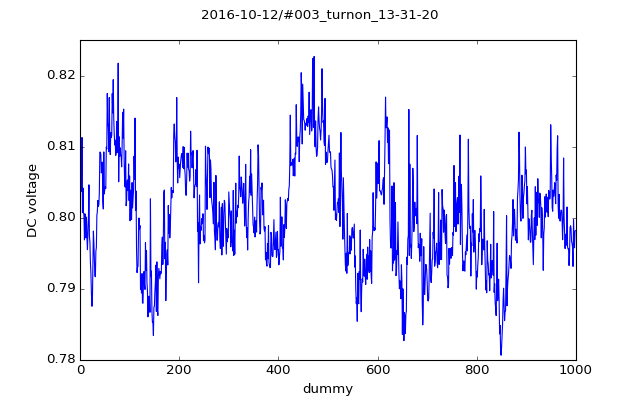

In [18]:
plot = qc.MatPlot()
plot.add(data.DC_voltage)

### Pinchoff

In [6]:
turnon_voltage = 1.9
pinchoff_vals = list(np.linspace(turnon_voltage, 0, 200))
gate = RB

turnon_param(turnon_voltage)
DC_parameter.setup()
data = qc.Loop(gate[pinchoff_vals]
               ).each(DC_parameter
                      ).then(qc.Task(pulsemaster.stop)
                             ).run(name='Pinchoff_{}'.format(gate.name),
                                   progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-10-12/#013_Pinchoff_RB_15-51-46'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | RB_set     | RB           | (200,)
   Measured | DC_voltage | DC_voltage   | (200,)
started at 2016-10-12 15:51:47


<IPython.core.display.Javascript object>


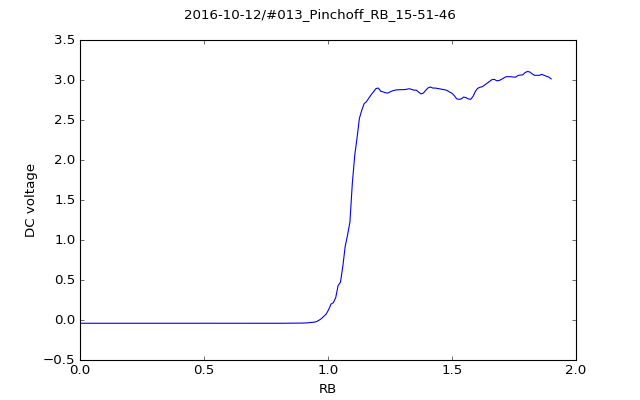

In [7]:
plot = qc.MatPlot()
plot.add(data.DC_voltage)

### 2D DC scans

DF_raw(2.57)
DS_raw(2.57)
LB_raw(3.8)
RB_raw(3.8)
SRC_raw(0.25
TG_raw(15.564)
TGAC_raw(1.842)


DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-10-13/#018_DF_DS_scan_10-37-37'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | DF_DS_set  | DF_DS        | (200,)
   Measured | DC_voltage | DC_voltage   | (200,)
started at 2016-10-13 10:37:39


<IPython.core.display.Javascript object>


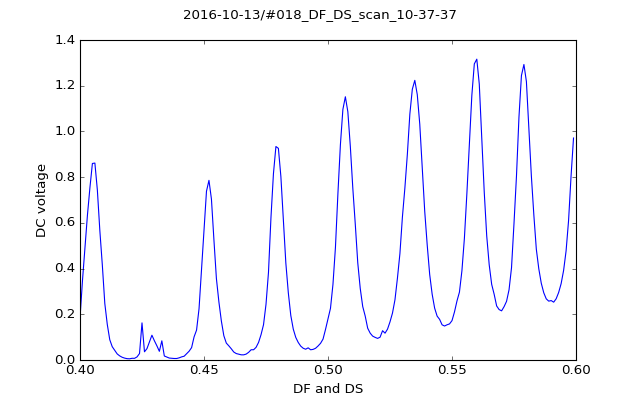

In [19]:
TGAC(0.5)
DC_parameter.setup()
data = qc.Loop(DF_DS[0.4:0.6:0.001]).each(DC_parameter).then(qc.Task(pulsemaster.stop)).run(name='DF_DS_scan')

plot = qc.MatPlot()
plot.add(data.DC_voltage)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-10-13/#017_DF_DS_scan_10-36-41'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | DF_DS_set  | DF_DS        | (200,)
   Measured | DC_voltage | DC_voltage   | (200,)
started at 2016-10-13 10:36:42


<IPython.core.display.Javascript object>


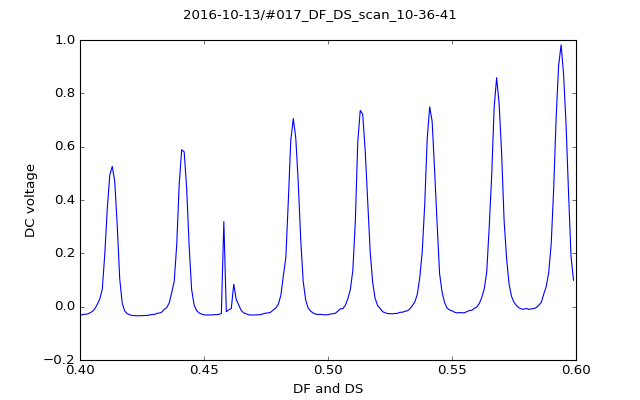

In [16]:
TGAC(0.5)
DC_parameter.setup()
data = qc.Loop(DF_DS[0.4:0.6:0.001]).each(DC_parameter).then(qc.Task(pulsemaster.stop)).run(name='DF_DS_scan')

plot = qc.MatPlot()
plot.add(data.DC_voltage)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-10-20/#002_DC_TGAC_vs_DF_DS_scan_08-32-00'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Setpoint | TGAC_set   | TGAC         | (40,)
   Setpoint | DF_DS_set  | DF_DS        | (40, 40)
   Measured | TG         | TG           | (40, 40)
   Measured | DC_voltage | DC_voltage   | (40, 40)
started at 2016-10-20 08:32:02


<IPython.core.display.Javascript object>


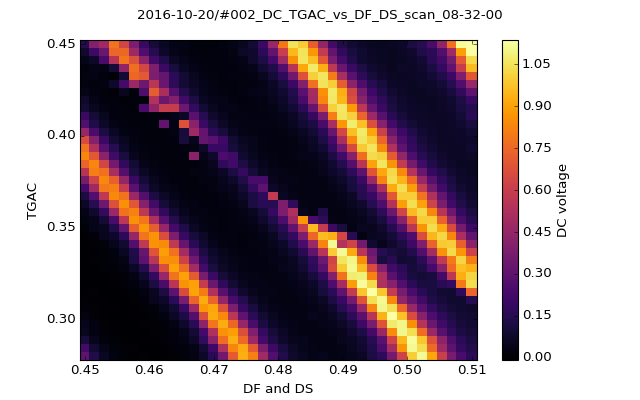

In [20]:
gate1 = TGAC
gate2 = DF_DS

# gate1_vals = list(np.linspace(0.3,0.7, 30))
# gate2_vals = list(np.linspace(0.4, 0.7, 80))
# gate1_vals = list(np.linspace(0.3,0.55, 50))
# gate2_vals = list(np.linspace(0.41, 0.53, 70))
gate1_vals = list(np.linspace(0.28,0.45, 40))
gate2_vals = list(np.linspace(0.45, 0.51, 40))

DC_parameter.setup()
data = qc.Loop(gate1[gate1_vals]
              ).loop(gate2[gate2_vals]
                    ).each(TG,DC_parameter
                          ).then(qc.Task(pulsemaster.stop)
                                ).run(name='DC_{}_vs_{}_scan'.format(gate1.name, gate2.name),
                                      progress_interval=True)

plot = qc.MatPlot()
plot.add(data.DC_voltage)

# ELRLR sequence

In [11]:
ELRLR_parameter.stages['read']['duration'] = 40

In [12]:
TGAC_vals = list(np.linspace(0.30,0.312,20))
DF_DS_vals = list(np.linspace(0.493, 0.5,16))

In [13]:
ELRLR_parameter.setup(samples=200)
data = qc.Loop(TGAC[TGAC_vals]
              ).loop(DF_DS[DF_DS_vals]
                    ).each(ELRLR_parameter
                          ).run(name='ELRLR_calibration',
                                progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-10-25/#003_ELRLR_calibration_16-58-55'
   <Type>   | <array_id>     | <array.name>   | <array.shape>
   Setpoint | TGAC_set       | TGAC           | (20,)
   Setpoint | DF_DS_set      | DF_DS          | (20, 16)
   Measured | fidelity_empty | fidelity_empty | (20, 16)
   Measured | fidelity_load  | fidelity_load  | (20, 16)
   Measured | fidelity_read  | fidelity_read  | (20, 16)
   Measured | up_proportion  | up_proportion  | (20, 16)
   Measured | dark_counts    | dark_counts    | (20, 16)
   Measured | contrast       | contrast       | (20, 16)
started at 2016-10-25 16:58:57


plotQ = qc.QtPlot()
plotQ.add(data.contrast)
plotQ = qc.QtPlot()
plotQ.add(data.dark_counts)
plotQ = qc.QtPlot()
plotQ.add(data.fidelity_load)
plotQ = qc.QtPlot()
plotQ.add(data.fidelity_empty)

<IPython.core.display.Javascript object>


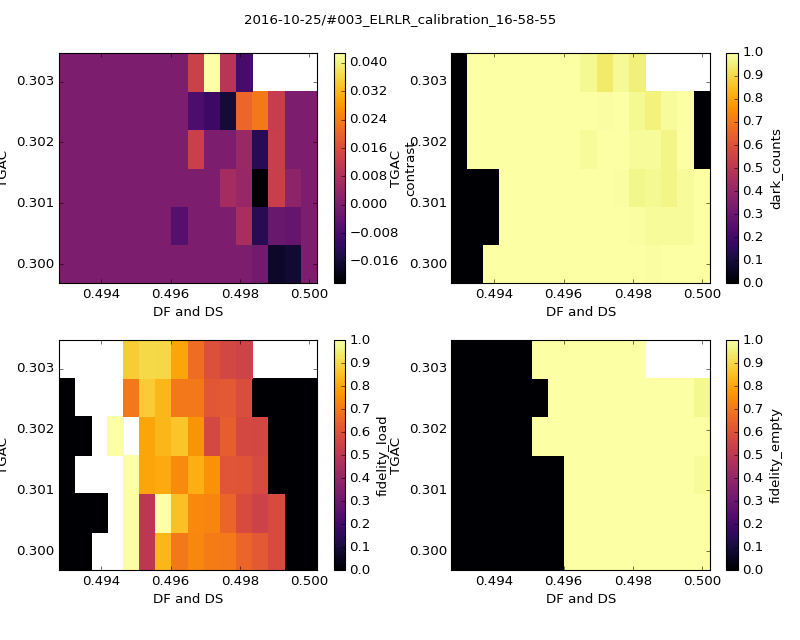

In [14]:
plot = qc.MatPlot(subplots=(2,2), figsize=(10,8))
plot.add(data.contrast, subplot=1, nticks=6)
plot.add(data.dark_counts, subplot=2, nticks=6)
plot.add(data.fidelity_load, subplot=3, nticks=6)
plot.add(data.fidelity_empty, subplot=4, nticks=6)
plot.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [35]:
pulsemaster.stop()

In [6]:
pulsemaster.start()

In [4]:
ELRLR_parameter.stages['read']['duration'] = 40

In [37]:
ELRLR_parameter.setup()

In [28]:
DC_parameter.setup()

In [ ]:
SRC(0.3)

In [11]:
TGAC(0.3066)
DF_DS(0.4976)

In [12]:
ELRLR_parameter.setup(samples=400, print=True)
ELRLR_parameter();

One peak found instead of two, lowering threshold
One peak found instead of two, lowering threshold
One peak found instead of two, lowering threshold
One peak found instead of two, lowering threshold
Could not find two peaks for empty and load state
fidelity_empty: 0.997
fidelity_load: 0.000
fidelity_read: 0.532
up_proportion: 0.705
dark_counts: 0.503
contrast: 0.203


In [26]:
ELRLR_parameter.setup(samples=400)
data = qc.Loop(SRC[0.15:0.33:0.01]
              ).each(ELRLR_parameter
                    ).run(name='ELRLR_vs_SRC',
                            progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-10-21/#007_ELRLR_vs_SRC_15-33-59'
   <Type>   | <array_id>     | <array.name>   | <array.shape>
   Setpoint | SRC_set        | SRC            | (18,)
   Measured | fidelity_empty | fidelity_empty | (18,)
   Measured | fidelity_load  | fidelity_load  | (18,)
   Measured | fidelity_read  | fidelity_read  | (18,)
   Measured | up_proportion  | up_proportion  | (18,)
   Measured | dark_counts    | dark_counts    | (18,)
   Measured | contrast       | contrast       | (18,)
started at 2016-10-21 15:34:01


# Read level sweep

In [10]:
variable_read_parameter.setup(samples=100)
data = qc.Loop(variable_read_parameter[-1.5:2.5:0.04]
                     ).each(variable_read_parameter
                           ).run(name='variable_read',
                                progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-10-18/#002_variable_read_14-11-31'
   <Type>   | <array_id>                | <array.name>          | <array.shape>
   Setpoint | variable_read_voltage_set | variable_read_voltage | (100,)
   Measured | index0                    | index0                | (100, 8992)
   Measured | Channel_A_signal          | Channel_A_signal      | (100, 8992)
   Measured | Channel_C_signal          | Channel_C_signal      | (100, 8992)
started at 2016-10-18 14:11:47


In [42]:
plotQ = qc.QtPlot()
plotQ.add(data.Channel_A_signal)

plotQ = qc.QtPlot()
plotQ.add(data.Channel_C_signal)

# T1 measurement

In [13]:
# Prepare measurements: Determine threshold voltage
ELR_parameter.setup(samples=300, return_traces=True)
_, _, _, _, _,traces, traces_AWG = ELR_parameter()
_, _, threshold_voltage = analysis.find_high_low(traces)
assert threshold_voltage is not None, "Couldn't find accurate threshold"
print('Threshold voltage found at {:.2f} V'.format(threshold_voltage))

Threshold voltage found at 0.20 V


In [14]:
# Calculate T1 durations (shuffled)
T1_wait_times = list(np.logspace(1,4.2,num=20,base=10))
np.random.shuffle(T1_wait_times)
print('Shuffled T1 wait times: {}'.format(T1_wait_times))

Shuffled T1 wait times: [15848.931924611141, 222.51967709560262, 10754.220761125622, 32.008340465997662, 102.45338593872233, 327.93628590208834, 712.24855848599145, 1049.6696290308787, 4951.500669473131, 7297.2276446863925, 1546.9407652462003, 150.98971606184202, 47.171991382132958, 21.719114020174249, 2279.789435643565, 3359.8182862837812, 483.29302385717523, 14.737406155824797, 10.0, 69.519279617756055]


In [4]:
# Single point T1 sweep
T1_parameter.setup(threshold_voltage=threshold_voltage, samples=30, data_manager=data_manager_raw)
T1_parameter(30000)
data = qc.Loop(dummy_param[0:30:1]
              ).each(T1_parameter
                    ).run(name='T1_data_high', progress_interval=True)

# plotQ = qc.QtPlot()
# plotQ.add(data.up_proportion)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-09-21/#001_T1_data_high_08-47-35'
   <Type>   | <array_id>        | <array.name>      | <array.shape>
   Setpoint | dummy_set         | dummy             | (30,)
   Measured | up_proportion     | up_proportion     | (30,)
   Measured | num_traces_loaded | num_traces_loaded | (30,)
started at 2016-09-21 08:47:37


DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-09-20/#039_T1_single_sweep_16-46-59'
   <Type>   | <array_id>        | <array.name>      | <array.shape>
   Setpoint | T1_wait_time_set  | T1_wait_time      | (20,)
   Measured | up_proportion     | up_proportion     | (20,)
   Measured | num_traces_loaded | num_traces_loaded | (20,)
started at 2016-09-20 16:47:00


<IPython.core.display.Javascript object>


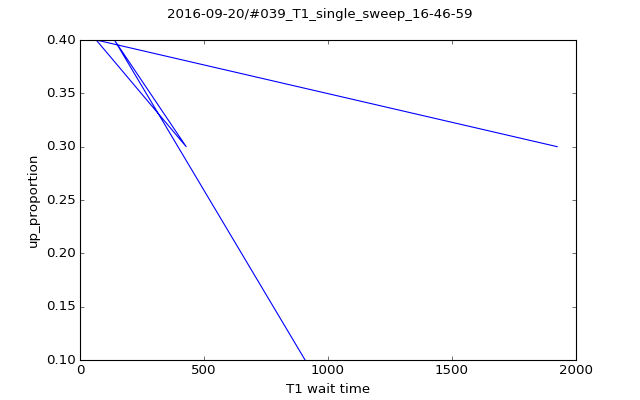

In [73]:
# Single T1 sweep
T1_parameter.setup(threshold_voltage=threshold_voltage, samples=10)

data = qc.Loop(T1_parameter[T1_wait_times]
                     ).each(T1_parameter
                           ).run(name='T1_single_sweep')

plotQ = qc.MatPlot()
plotQ.add(data.up_proportion)

In [15]:
# Continuous T1 sweep
setup_ELRLR = partial(ELRLR_parameter.setup, samples=400, data_manager=data_manager_raw)
setup_T1 = partial(T1_parameter.setup, threshold_voltage=threshold_voltage, samples=150, data_manager=data_manager_raw)
setup_ELRLR()
setup_T1()
data = qc.Loop(dummy_param[0:30:1]
              ).each(qc.Task(setup_ELRLR),
                     ELRLR_parameter,
                     qc.Task(setup_T1),
                     qc.Loop(T1_parameter[T1_wait_times]).each(T1_parameter)
                    ).run(name='T1_data', progress_interval=True)

# plotQ = qc.QtPlot()
# plotQ.add(data.up_proportion)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-10-21/#009_T1_data_17-09-21'
   <Type>   | <array_id>          | <array.name>      | <array.shape>
   Setpoint | dummy_set           | dummy             | (30,)
   Measured | fidelity_empty      | fidelity_empty    | (30,)
   Measured | fidelity_load       | fidelity_load     | (30,)
   Measured | fidelity_read       | fidelity_read     | (30,)
   Measured | up_proportion_1_3   | up_proportion     | (30,)
   Measured | dark_counts         | dark_counts       | (30,)
   Measured | contrast            | contrast          | (30,)
   Setpoint | T1_wait_time_set    | T1_wait_time      | (30, 20)
   Measured | up_proportion_3_0_0 | up_proportion     | (30, 20)
   Measured | num_traces_loaded   | num_traces_loaded | (30, 20)
started at 2016-10-21 17:09:23


In [19]:
data.sync()
print(data.T1_wait_time_set[0])
data.up_proportion_3_0_0[29]

[  1.58489000e+04   2.22520000e+02   1.07542000e+04   3.20083000e+01
   1.02453000e+02   3.27936000e+02   7.12249000e+02   1.04967000e+03
   4.95150000e+03   7.29723000e+03   1.54694000e+03   1.50990000e+02
   4.71720000e+01   2.17191000e+01   2.27979000e+03   3.35982000e+03
   4.83293000e+02   1.47374000e+01   1.00000000e+01   6.95193000e+01]


array([ 0.14094 ,  0.42    ,  0.193333,  0.510067,  0.463087,  0.436242,
        0.422819,  0.42953 ,  0.194631,  0.213333,  0.342282,  0.433333,
        0.44    ,  0.418919,  0.328859,  0.263514,  0.456376,  0.483221,
        0.436242,  0.44898 ])